In [11]:

import dgl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
import torch
import warnings
import yfinance as yf

from utils import build_nx_graph, gen_q_dict_mis, qubo_dict_to_torch, \
    get_gnn, run_gnn_training, loss_func, postprocess_gnn_mis, run_mis_solver
from utils_backtest import portfolio_return, drawdown, sharpe_ratio, sortino_ratio, \
    max_drawdown, calmar_ratio
from utils_distance_correlation import dcor

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [12]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


## Read in Data

In [13]:
sp500_hist = pd.read_csv(
    "sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

# drop columns with more than 60% NaN values
sp500_hist.dropna(axis=1, thresh=int(len(sp500_hist)*0.4), inplace=True)

# drop columns with negative values in it
sp500_hist.drop(
    columns=sp500_hist.columns[(sp500_hist < 0).any()].values, 
    axis=1,
    inplace=True)

print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (4279, 484)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,20.439508,35.305668,38.559849,2.272182,NaN,16.348289,12.590348,6.120000,21.528095,38.520000,...,29.771492,9.832613,32.591091,24.051765,NaN,12.118679,60.463249,42.830002,58.061222,NaN
2006-01-04,20.494427,36.955471,38.834522,2.278869,NaN,16.239967,12.609449,6.151111,21.645647,38.419998,...,29.716309,9.880271,32.646824,24.274343,NaN,12.222367,61.037167,42.410000,58.471172,NaN
2006-01-05,21.031340,37.436260,39.020573,2.260936,NaN,16.038809,12.771802,6.061111,21.807291,38.070000,...,29.539726,9.874971,32.485168,23.998352,NaN,12.743404,60.392624,42.529999,59.002590,NaN
2006-01-06,21.141167,36.766926,38.976273,2.319297,NaN,15.860854,13.016929,6.173333,22.887375,39.000000,...,29.821157,9.912039,33.126179,24.372272,NaN,12.707114,60.083572,44.119999,59.617485,NaN
2006-01-09,21.080151,36.399242,39.481319,2.311697,NaN,15.860854,13.500801,6.116667,22.821247,38.380001,...,31.228340,9.885561,33.109463,24.612658,NaN,12.805617,62.211487,44.790001,59.124062,NaN


### S&P500 as Benchmark

In [14]:
gspc = yf.download(
    tickers="^GSPC", 
    start=sp500_hist.index[0].strftime(format="%Y-%m-%d"), 
    end=sp500_hist.index[-1].strftime(format="%Y-%m-%d")
)['Adj Close']

gspc

[*********************100%***********************]  1 of 1 completed


Date
2006-01-03    1268.800049
2006-01-04    1273.459961
2006-01-05    1273.479980
2006-01-06    1285.449951
2006-01-09    1290.150024
                 ...     
2022-12-22    3822.389893
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
Name: Adj Close, Length: 4278, dtype: float64

In [15]:
TRAIN_START_DATE, TRAIN_END_DATE = "2009-01-01", "2019-01-01"
VAL_START_DATE, VAL_END_DATE = TRAIN_END_DATE, "2020-01-01"
TEST_START_DATE, TEST_END_DATE = VAL_END_DATE, "2022-12-30"

df_train = sp500_hist.loc[TRAIN_START_DATE:TRAIN_END_DATE,:]
df_val = sp500_hist.loc[VAL_START_DATE:VAL_END_DATE,:]
df_test = sp500_hist.loc[TEST_START_DATE:TEST_END_DATE,:]

gspc_train = gspc.loc[TRAIN_START_DATE:TRAIN_END_DATE]
gspc_val = gspc.loc[VAL_START_DATE:VAL_END_DATE]
gspc_test = gspc.loc[TEST_START_DATE:TEST_END_DATE]

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

assert df_train.shape[1] == df_val.shape[1] and df_val.shape[1] == df_test.shape[1]
assert df_train.shape[0] == gspc_train.shape[0] 
assert df_val.shape[0] == gspc_val.shape[0]
assert df_test.shape[0] == gspc_test.shape[0] + 1


Train shape: (2516, 484)
Validation shape: (252, 484)
Test shape: (756, 484)


### Build correlation matrix

In [16]:
METHOD = 'pct'
CORR_METHOD = 'pearson'

if METHOD == 'standard':
    df_corr = df_train.corr(method=CORR_METHOD).abs()
elif METHOD == 'pct':
    df_train_pct = df_train.pct_change()
    df_corr = df_train_pct.corr(method=CORR_METHOD).abs()
elif METHOD == 'pct_yearly':
    df_train_pct = df_train.pct_change()
    df_train_pct = df_train_pct.groupby(df_train_pct.index.year).sum()
    df_corr = df_train_pct.corr(method=CORR_METHOD).abs()
elif METHOD == 'drawdown':
    df_mdd = df_train.apply(lambda x: drawdown(x))
    df_corr = df_mdd.corr(method=CORR_METHOD).abs()
else:
    raise KeyError("METHOD must be either 'standard', 'pct' or 'pct_yearly'.")

# df_train_pct = df_train.pct_change()
# df_corr = df_train_pct.corr(method=dcor)

df_corr

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.377490,0.278648,0.426086,0.395127,0.395715,0.436315,0.451611,0.542658,0.528511,...,0.446320,0.321330,0.521572,0.543987,0.466992,0.454588,0.496955,0.455587,0.453823,0.421125
AAL,0.377490,1.000000,0.222802,0.281358,0.230219,0.247036,0.245888,0.358579,0.280142,0.336947,...,0.362016,0.194477,0.258093,0.328868,0.261922,0.335371,0.299906,0.262792,0.350474,0.289608
AAP,0.278648,0.222802,1.000000,0.212792,0.210450,0.208975,0.254871,0.238312,0.253933,0.230069,...,0.208382,0.209497,0.254363,0.268908,0.256026,0.307996,0.250243,0.257291,0.249090,0.205259
AAPL,0.426086,0.281358,0.212792,1.000000,0.211185,0.264085,0.306288,0.313199,0.386224,0.406557,...,0.383202,0.212159,0.363080,0.346439,0.294178,0.386315,0.356456,0.351841,0.346793,0.298356
ABBV,0.395127,0.230219,0.210450,0.211185,1.000000,0.357279,0.444119,0.201294,0.332795,0.317001,...,0.224578,0.163817,0.307661,0.325147,0.313689,0.237877,0.392381,0.239003,0.290284,0.390879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.454588,0.335371,0.307996,0.386315,0.237877,0.286077,0.351322,0.378501,0.414654,0.432484,...,0.381711,0.306293,0.414353,0.384837,0.351290,1.000000,0.359590,0.340433,0.380528,0.292869
ZBH,0.496955,0.299906,0.250243,0.356456,0.392381,0.367133,0.475346,0.359583,0.422443,0.401029,...,0.345810,0.289338,0.443852,0.516767,0.355353,0.359590,1.000000,0.342208,0.387854,0.350850
ZBRA,0.455587,0.262792,0.257291,0.351841,0.239003,0.269297,0.311975,0.318131,0.402669,0.389423,...,0.349209,0.186168,0.393325,0.296350,0.329922,0.340433,0.342208,1.000000,0.319799,0.293736
ZION,0.453823,0.350474,0.249090,0.346793,0.290284,0.246266,0.279019,0.457824,0.371702,0.372629,...,0.418244,0.175014,0.419720,0.409550,0.415076,0.380528,0.387854,0.319799,1.000000,0.294470


In [17]:
df_corr.quantile(0.5).mean()

0.359697136322241

In [18]:
STOCK_NAMES = df_corr.columns.values

## Build Graph

In [19]:
THRESHOLD = 0.5

nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=THRESHOLD
)

# assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'
assert (df_corr.where(df_corr >= THRESHOLD).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

In [25]:
len(nx_graph.edges)

11750

### Plot degree distribution

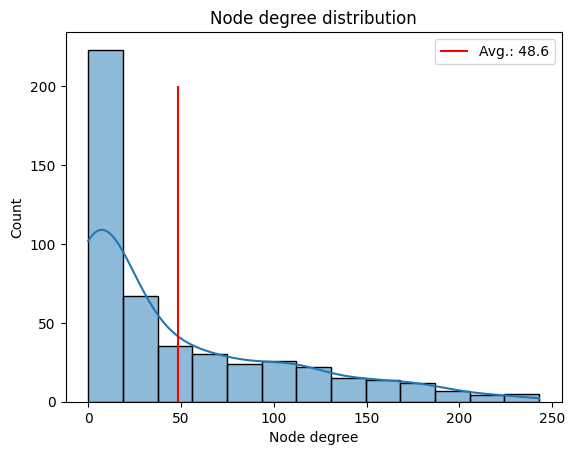

In [24]:
degrees = [degree for (node, degree) in nx_graph.degree()]
avg_degree = sum(degrees) / len(degrees)

sns.histplot(degrees, kde=True)
plt.vlines(avg_degree, ymin=0, ymax=200, colors=['r'], label=f"Avg.: {avg_degree:.1f}")
plt.title("Node degree distribution")
plt.xlabel("Node degree")
plt.legend()
plt.show()

### Build Q matrix

In [21]:
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

### Visualize graph

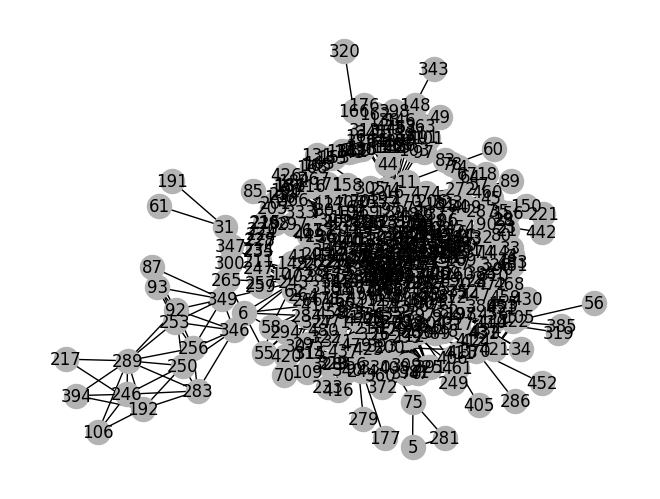

In [22]:
if len(nx_graph.nodes) < 500:
    pos = nx.kamada_kawai_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

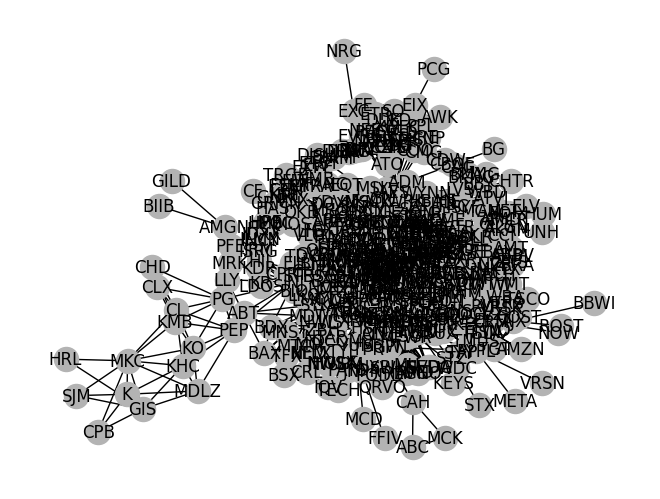

In [23]:
# nx_graph_labelled_vis = nx.relabel_nodes(nx_graph, lambda x: STOCK_NAMES[x])
# pos_labelled_vis = nx.kamada_kawai_layout(nx_graph_labelled_vis)
# nx.draw(nx_graph_labelled_vis, pos_labelled_vis, with_labels=True, node_color=[[.7, .7, .7]])

## Set up GNN

In [14]:
# best set of parameters according to 
# hyperparameter tuning

params = {'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 50000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [15]:
n = len(nx_graph.nodes)

net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE
)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

## Run GNN training

In [16]:
print('Running GNN...')
gnn_start = time()

net, embed, optimizer = get_gnn(
    n_nodes=n, 
    params=params, 
    model_type=params["model"], 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE)   
    
net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
    q_torch=q_torch, 
    dgl_graph=graph_dgl, 
    net=net, 
    embed=embed, 
    optimizer=optimizer, 
    number_epochs=params['number_epochs'],
    tol=params['tolerance'], 
    patience=params['patience'], 
    prob_threshold=params['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 77292.5390625
Epoch: 1000, Loss: 0.39891162514686584
Epoch: 2000, Loss: -6.536989212036133
Epoch: 3000, Loss: -16.12465476989746
Epoch: 4000, Loss: -27.869464874267578
Epoch: 5000, Loss: -31.835416793823242
Epoch: 6000, Loss: -32.21776580810547
Epoch: 7000, Loss: -35.210941314697266
Epoch: 8000, Loss: -39.683204650878906
Epoch: 9000, Loss: -37.08232116699219
Epoch: 10000, Loss: -39.20285415649414
Epoch: 11000, Loss: -41.902252197265625
Epoch: 12000, Loss: -49.39883804321289
Epoch: 13000, Loss: -55.173622131347656
Epoch: 14000, Loss: -65.79881286621094
Epoch: 15000, Loss: -72.45732879638672
Epoch: 16000, Loss: -78.42705535888672
Epoch: 17000, Loss: -86.65025329589844
Epoch: 18000, Loss: -89.47626495361328
Epoch: 19000, Loss: -89.83280944824219
Epoch: 20000, Loss: -92.87287139892578
Epoch: 21000, Loss: -93.7204818725586
Epoch: 22000, Loss: -94.33518981933594
Epoch: 23000, Loss: -94.82357025146484
Epoch: 24000, Loss: -95.96707916259766
Epoch: 25000, Loss: -9

## Post-process GNN Results

In [17]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis_gnn} with {number_violations_gnn} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 102 with 0 violations
Took 477.195s, model training took 476.99s


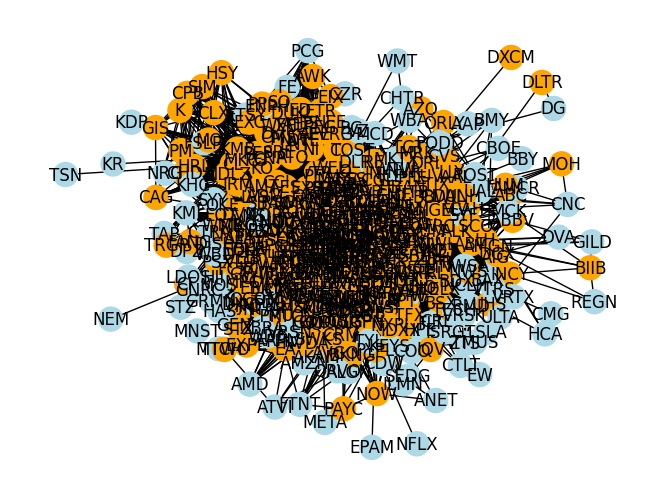

In [18]:
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [19]:
gnn_mis_set = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

## Compare against traditional solver

In [20]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=484).
Calculating violations...
Independence number found by nx solver is 97 with 0 violations.
MIS solver took 7.434s


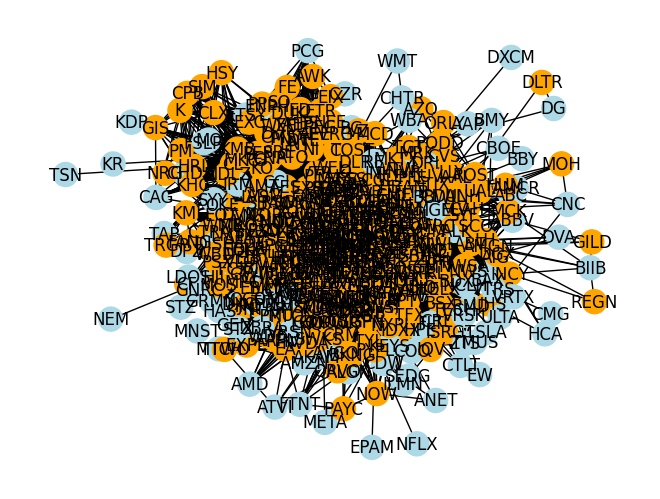

In [21]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [22]:
solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

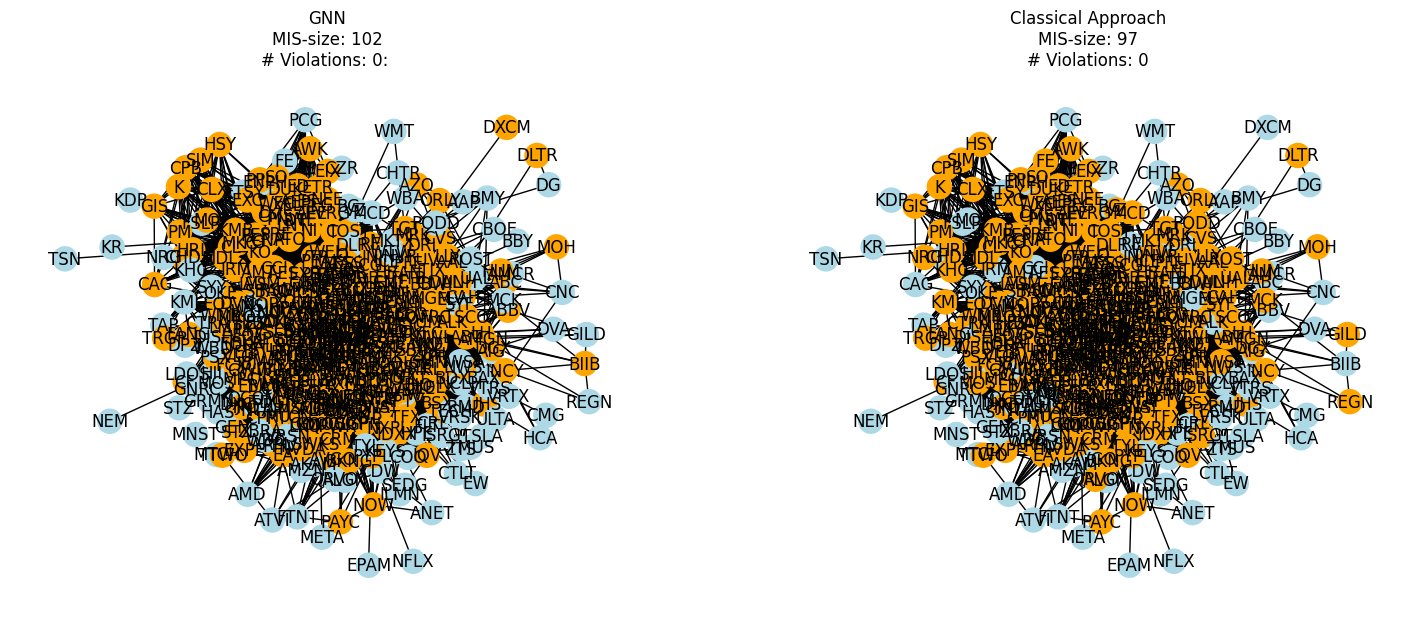

In [23]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# GNN
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax0)
ax0.set_title(f"GNN\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

In [24]:
df_mis = pd.concat([
    pd.DataFrame(
        data={'gnn': gnn_mis_set},
        index=gnn_mis_set
    ),
    pd.DataFrame(
        data={'solver': solver_mis_set},
        index=solver_mis_set
    )
],
axis=1)

df_mis

,gnn,solver
AAP,AAP,AAP
AIG,AIG,AIG
AKAM,AKAM,AKAM
ALGN,ALGN,ALGN
AMCR,AMCR,AMCR
...,...,...
NVR,NaN,NVR
NWS,NaN,NWS
RE,NaN,RE
STX,NaN,STX


In [25]:
# intersection
df_intersec = df_mis.dropna(axis=0)
print(f"Length: {len(df_intersec)}")
df_intersec

Length: 73


,gnn,solver
AAP,AAP,AAP
AIG,AIG,AIG
AKAM,AKAM,AKAM
ALGN,ALGN,ALGN
AMCR,AMCR,AMCR
...,...,...
VTRS,VTRS,VTRS
WBA,WBA,WBA
WMT,WMT,WMT
ZBRA,ZBRA,ZBRA


In [26]:
# Not intersecting
df_non_intersec = df_mis.drop(index=df_intersec.index)
print(f"Length: {len(df_non_intersec)}")
df_non_intersec

Length: 53


,gnn,solver
CTRA,CTRA,NaN
DLR,DLR,NaN
EL,EL,NaN
FE,FE,NaN
GILD,GILD,NaN
GWW,GWW,NaN
ISRG,ISRG,NaN
KHC,KHC,NaN
KMI,KMI,NaN
MCD,MCD,NaN


## Backtest

In [27]:
CAPITAL = 100_000

In [28]:
# #https://www.codearmo.com/blog/sharpe-sortino-and-calmar-ratios-python

# N_TRADING_DAYS = 252
# RISK_FREE_RATE = 0.01





In [29]:
def drawdown_pct(return_series):
    rs_max = return_series.rolling(
        window=len(return_series), 
        min_periods=1
        ).max()
    return return_series - rs_max

In [30]:
# def drawdown_pct(return_series):
#     rs_max = return_series.rolling(
#         window=len(return_series), 
#         min_periods=1
#         ).max()
#     return return_series - rs_max


# ppr = gnn_mis_returns_cum_val
# ppr_max = ppr.rolling(window=len(ppr), min_periods=1).max()
# ppr.plot()
# ppr_max.plot()
# plt.show()

In [31]:
# (ppr - ppr_max).plot()

In [32]:
# ppr.rolling(window=len(ppr), min_periods=1).max()

### Validation

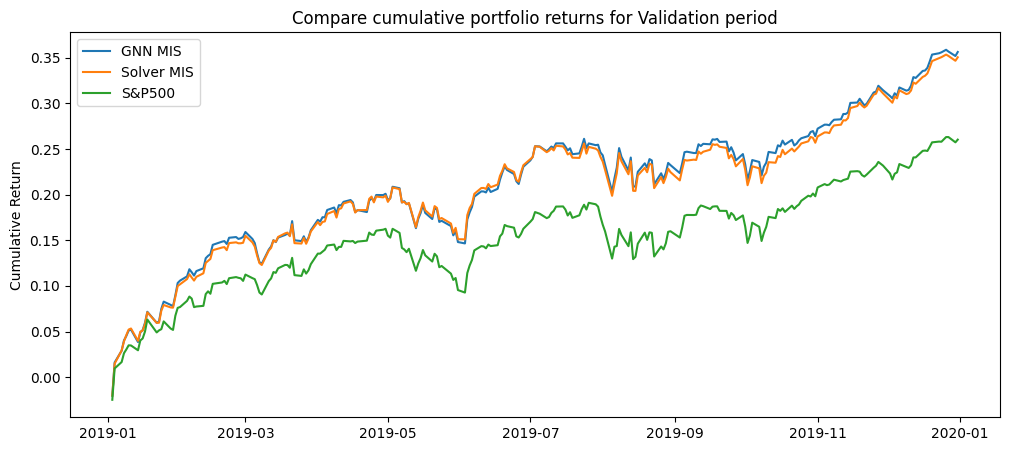

In [33]:
# GNN MIS Portfolio
gnn_mis_returns_val, gnn_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_val, solver_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_val = gspc_val.pct_change()
gspc_returns_cum_val = gspc_returns_val.cumsum()
# gspc_returns_cum_val_1 = ((gspc_val.pct_change() +1 ).cumprod()) -1


# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_val, label="GNN MIS")
plt.plot(solver_mis_returns_cum_val, label="Solver MIS")
plt.plot(gspc_returns_cum_val, label="S&P500")
# plt.plot(gspc_returns_cum_val_1, label="S&P500_1")


plt.title("Compare cumulative portfolio returns for Validation period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

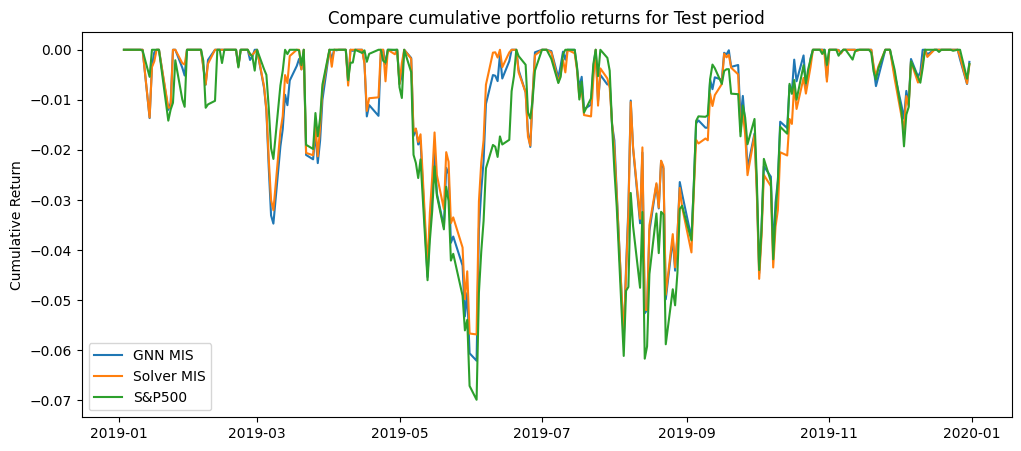

In [34]:
gnn_mis_mdd_val = drawdown_pct(gnn_mis_returns_cum_val)
solver_mis_mdd_val = drawdown_pct(solver_mis_returns_cum_val)
gspc_mdd_val = drawdown_pct(gspc_returns_cum_val)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_val, label="GNN MIS")
plt.plot(solver_mis_mdd_val, label="Solver MIS")
plt.plot(gspc_mdd_val, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [35]:
# Sharpe Ratio
gnn_mis_sharpe_ratio = sharpe_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_sharpe_ratio = sharpe_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_sharpe_ratio = sharpe_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS sharpe ratio: {gnn_mis_sharpe_ratio:.2f}")
print(f"Solver MIS sharpe ratio: {solver_mis_sharpe_ratio:.2f}")
print(f"S&P500 sharpe ratio: {gspc_sharpe_ratio:.2f}\n")

# Sortino Ratio
gnn_mis_sortino_ratio = sortino_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_sortino_ratio = sortino_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_sortino_ratio = sortino_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS sortino ratio: {gnn_mis_sortino_ratio:.2f}")
print(f"Solver MIS sortino ratio: {solver_mis_sortino_ratio:.2f}")
print(f"S&P500 sortino ratio: {gspc_sortino_ratio:.2f}\n")

# Maximal drawdown
gnn_mis_mdd = max_drawdown(return_series=gnn_mis_returns_val)
solver_mis_mdd = max_drawdown(return_series=solver_mis_returns_val)
gspc_mdd = max_drawdown(return_series=gspc_returns_val)

print(f"GNN MIS MDD: {gnn_mis_mdd:.2f}")
print(f"Solver MIS MDD: {solver_mis_mdd:.2f}")
print(f"S&P500 MDD: {gspc_mdd:.2f}\n")

# Calmar ratio
gnn_mis_calmar_ratio = calmar_ratio(return_series=gnn_mis_returns_val, N=252, rf=0.01)
solver_mis_calmar_ratio = calmar_ratio(return_series=solver_mis_returns_val, N=252, rf=0.01)
gspc_calmar_ratio = calmar_ratio(return_series=gspc_returns_val, N=252, rf=0.01)

print(f"GNN MIS calmar ratio: {gnn_mis_calmar_ratio:.2f}")
print(f"Solver MIS calmar ratio: {solver_mis_calmar_ratio:.2f}")
print(f"S&P500 calmar ratio: {gspc_calmar_ratio:.2f}")


GNN MIS sharpe ratio: 2.58
Solver MIS sharpe ratio: 2.58
S&P500 sharpe ratio: 2.01

GNN MIS sortino ratio: 3.34
Solver MIS sortino ratio: 3.35
S&P500 sortino ratio: 2.49

GNN MIS MDD: -0.06
Solver MIS MDD: -0.06
S&P500 MDD: -0.07

GNN MIS calmar ratio: -5.69
Solver MIS calmar ratio: -6.07
S&P500 calmar ratio: -3.68


In [36]:
pd.DataFrame(
    data={
        "sharpe_gnn": [gnn_mis_sharpe_ratio],
        "sharpe_solver": [solver_mis_sharpe_ratio],
        "sharpe_SP500": [gspc_sharpe_ratio],
    },
    index=[2019]
)

,sharpe_gnn,sharpe_solver,sharpe_SP500
2019,2.583029,2.576446,2.011341


### Test

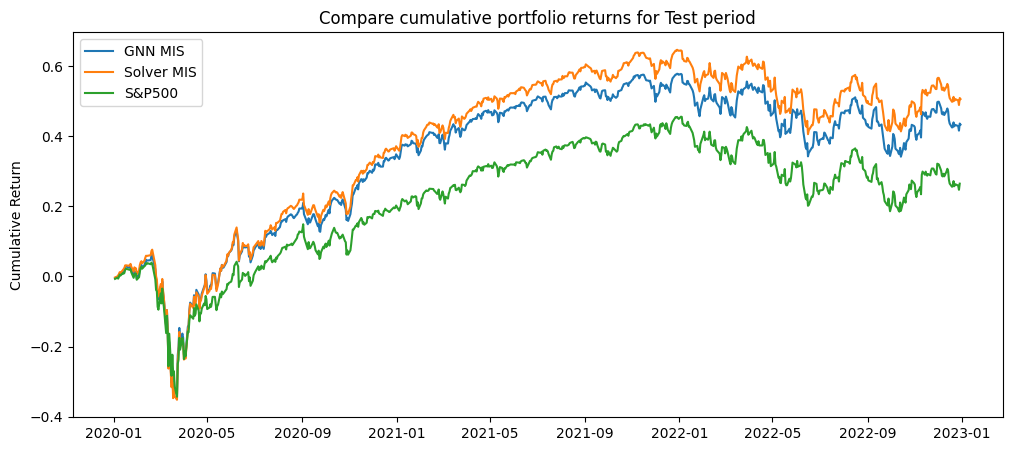

In [37]:
# GNN MIS Portfolio
gnn_mis_returns_test, gnn_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_test, solver_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_test = gspc_test.pct_change()
gspc_returns_cum_test = gspc_returns_test.cumsum()

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_test, label="GNN MIS")
plt.plot(solver_mis_returns_cum_test, label="Solver MIS")
plt.plot(gspc_returns_cum_test, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

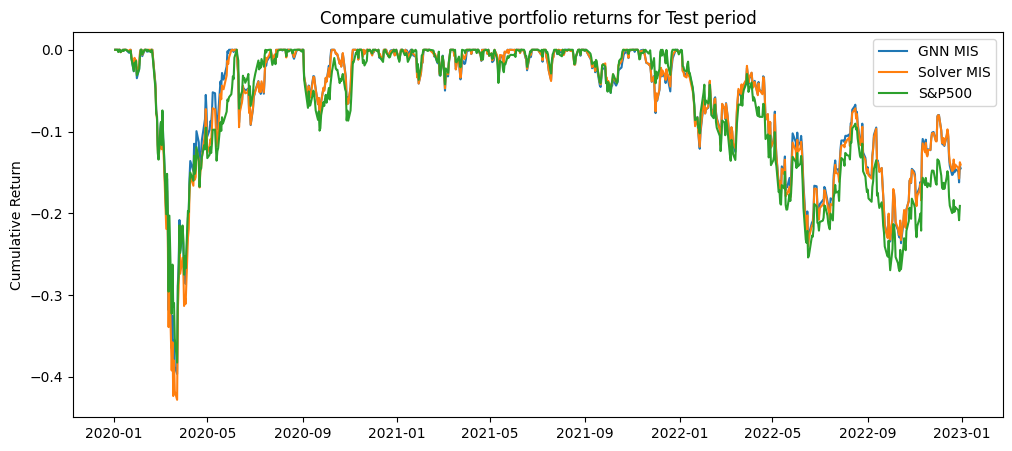

In [38]:
gnn_mis_mdd_test = drawdown_pct(gnn_mis_returns_cum_test)
solver_mis_mdd_test = drawdown_pct(solver_mis_returns_cum_test)
gspc_mdd_test = drawdown_pct(gspc_returns_cum_test)

# gnn_mis_mdd_val = drawdown(gnn_mis_returns_cum_val)
# solver_mis_mdd_val = drawdown(solver_mis_returns_cum_val)
# gspc_mdd_val = drawdown(gspc_returns_cum_val)


# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_test, label="GNN MIS")
plt.plot(solver_mis_mdd_test, label="Solver MIS")
plt.plot(gspc_mdd_test, label="S&P500")
# plt.hlines(0, xmin=gnn_mis_mdd_test.index[0], xmax=gnn_mis_mdd_test.index[-1])
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [39]:
# Sharpe Ratio
gnn_mis_sharpe_ratio = sharpe_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_sharpe_ratio = sharpe_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_sharpe_ratio = sharpe_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS sharpe ratio: {gnn_mis_sharpe_ratio:.2f}")
print(f"Solver MIS sharpe ratio: {solver_mis_sharpe_ratio:.2f}")
print(f"S&P500 sharpe ratio: {gspc_sharpe_ratio:.2f}\n")

# Sortino Ratio
gnn_mis_sortino_ratio = sortino_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_sortino_ratio = sortino_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_sortino_ratio = sortino_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS sortino ratio: {gnn_mis_sortino_ratio:.2f}")
print(f"Solver MIS sortino ratio: {solver_mis_sortino_ratio:.2f}")
print(f"S&P500 sortino ratio: {gspc_sortino_ratio:.2f}\n")

# Maximal drawdown
gnn_mis_mdd = max_drawdown(return_series=gnn_mis_returns_test)
solver_mis_mdd = max_drawdown(return_series=solver_mis_returns_test)
gspc_mdd = max_drawdown(return_series=gspc_returns_test)

print(f"GNN MIS MDD: {gnn_mis_mdd:.2f}")
print(f"Solver MIS MDD: {solver_mis_mdd:.2f}")
print(f"S&P500 MDD: {gspc_mdd:.2f}\n")

# Calmar ratio
gnn_mis_calmar_ratio = calmar_ratio(return_series=gnn_mis_returns_test, N=252, rf=0.01)
solver_mis_calmar_ratio = calmar_ratio(return_series=solver_mis_returns_test, N=252, rf=0.01)
gspc_calmar_ratio = calmar_ratio(return_series=gspc_returns_test, N=252, rf=0.01)

print(f"GNN MIS calmar ratio: {gnn_mis_calmar_ratio:.2f}")
print(f"Solver MIS calmar ratio: {solver_mis_calmar_ratio:.2f}")
print(f"S&P500 calmar ratio: {gspc_calmar_ratio:.2f}")


GNN MIS sharpe ratio: 0.51
Solver MIS sharpe ratio: 0.60
S&P500 sharpe ratio: 0.31

GNN MIS sortino ratio: 0.63
Solver MIS sortino ratio: 0.73
S&P500 sortino ratio: 0.38

GNN MIS MDD: -0.35
Solver MIS MDD: -0.37
S&P500 MDD: -0.34

GNN MIS calmar ratio: -0.39
Solver MIS calmar ratio: -0.43
S&P500 calmar ratio: -0.23
